In [3]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
# import pymc_bart as pmb

from scipy import stats

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v3.11.4


In [4]:
%config InlineBackend.figure_format = "retina"
RANDOM_SEED = 5781
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

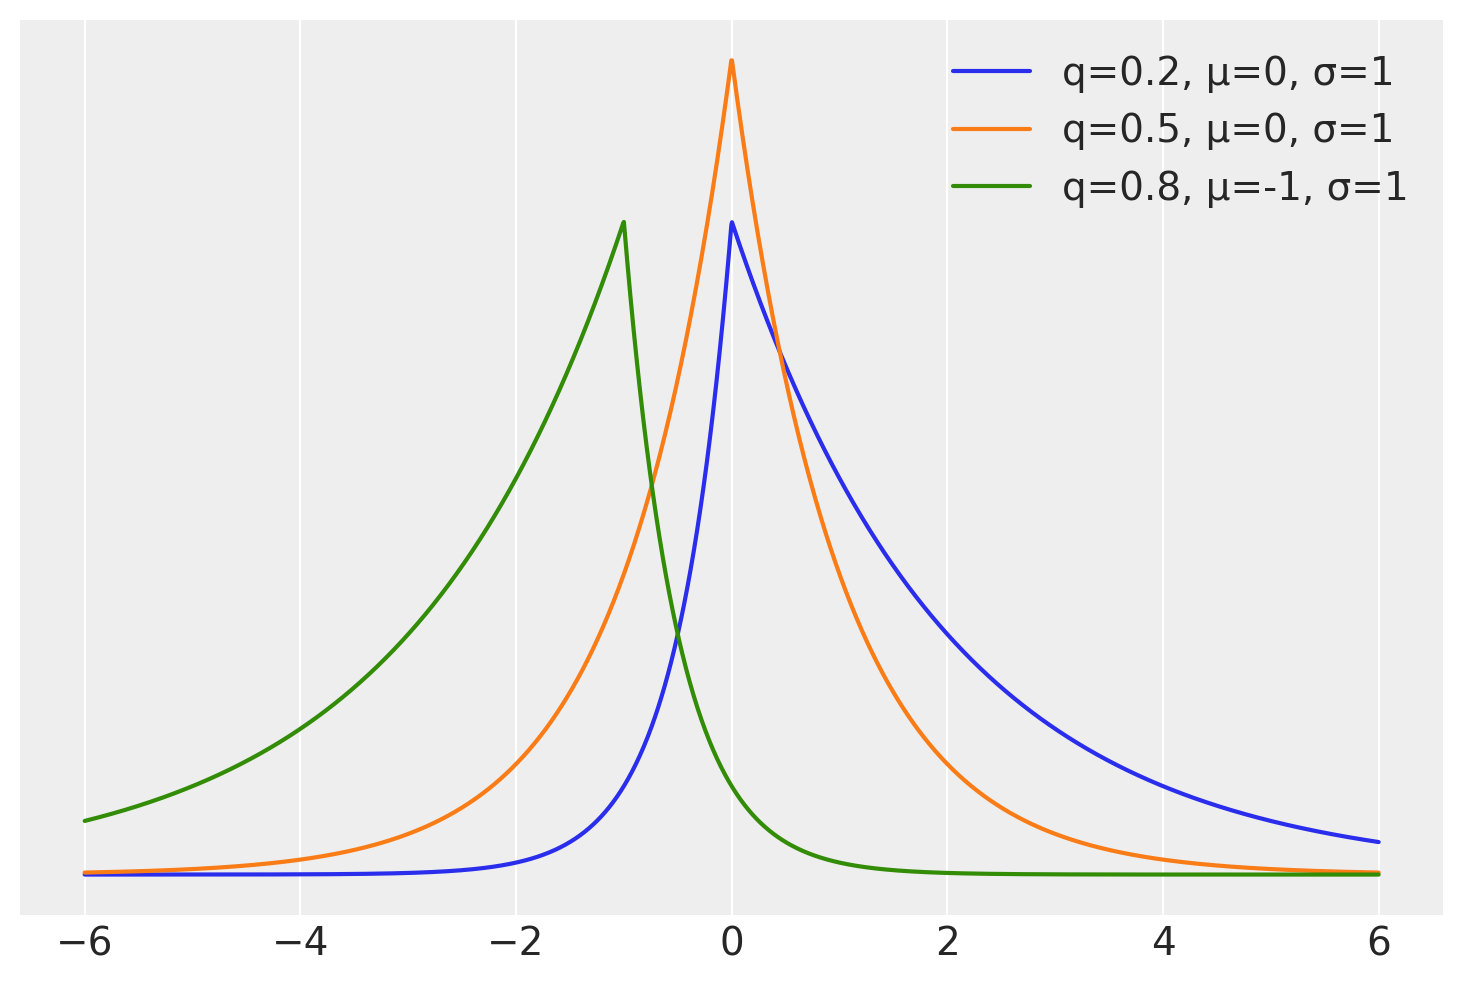

In [5]:
x = np.linspace(-6, 6, 2000)
for q, m in zip([0.2, 0.5, 0.8], [0, 0, -1]):
    κ = (q / (1 - q)) ** 0.5
    plt.plot(x, stats.laplace_asymmetric(κ, m, 1).pdf(x), label=f"q={q:}, μ={m}, σ=1")
plt.yticks([])
plt.legend();

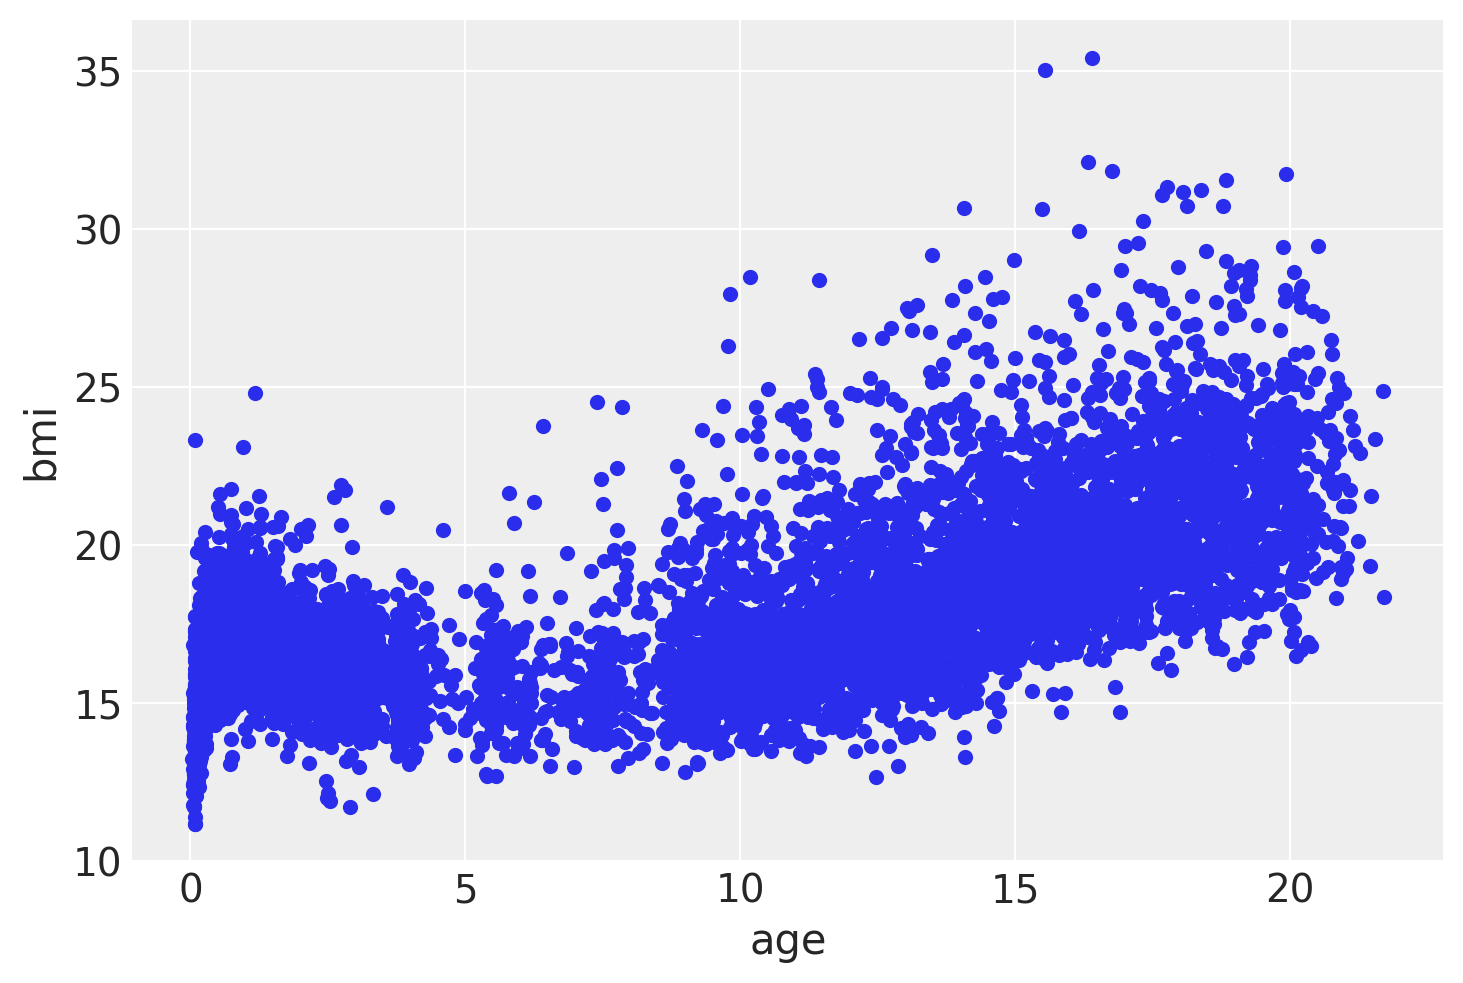

In [6]:
try:
    bmi = pd.read_csv(Path("..", "data", "bmi.csv"))
except FileNotFoundError:
    bmi = pd.read_csv(pm.get_data("bmi.csv"))

bmi.plot(x="age", y="bmi", kind="scatter");

In [7]:
y = bmi.bmi.values
X = bmi.age.values[:, None]


y_stack = np.stack([bmi.bmi.values] * 3)
quantiles = np.array([[0.1, 0.5, 0.9]]).T
quantiles

array([[0.1],
       [0.5],
       [0.9]])

In [8]:
with pm.Model() as model:
    μ = pm.BART("μ", X, y, shape=(3, 7294))
    σ = pm.HalfNormal("σ", 5)
    obs = pm.AsymmetricLaplace("obs", mu=μ, b=σ, q=quantiles, observed=y_stack)

    idata = pm.sample(compute_convergence_checks=False)

TypeError: __init__() got an unexpected keyword argument 'shape'

NameError: name 'idata' is not defined

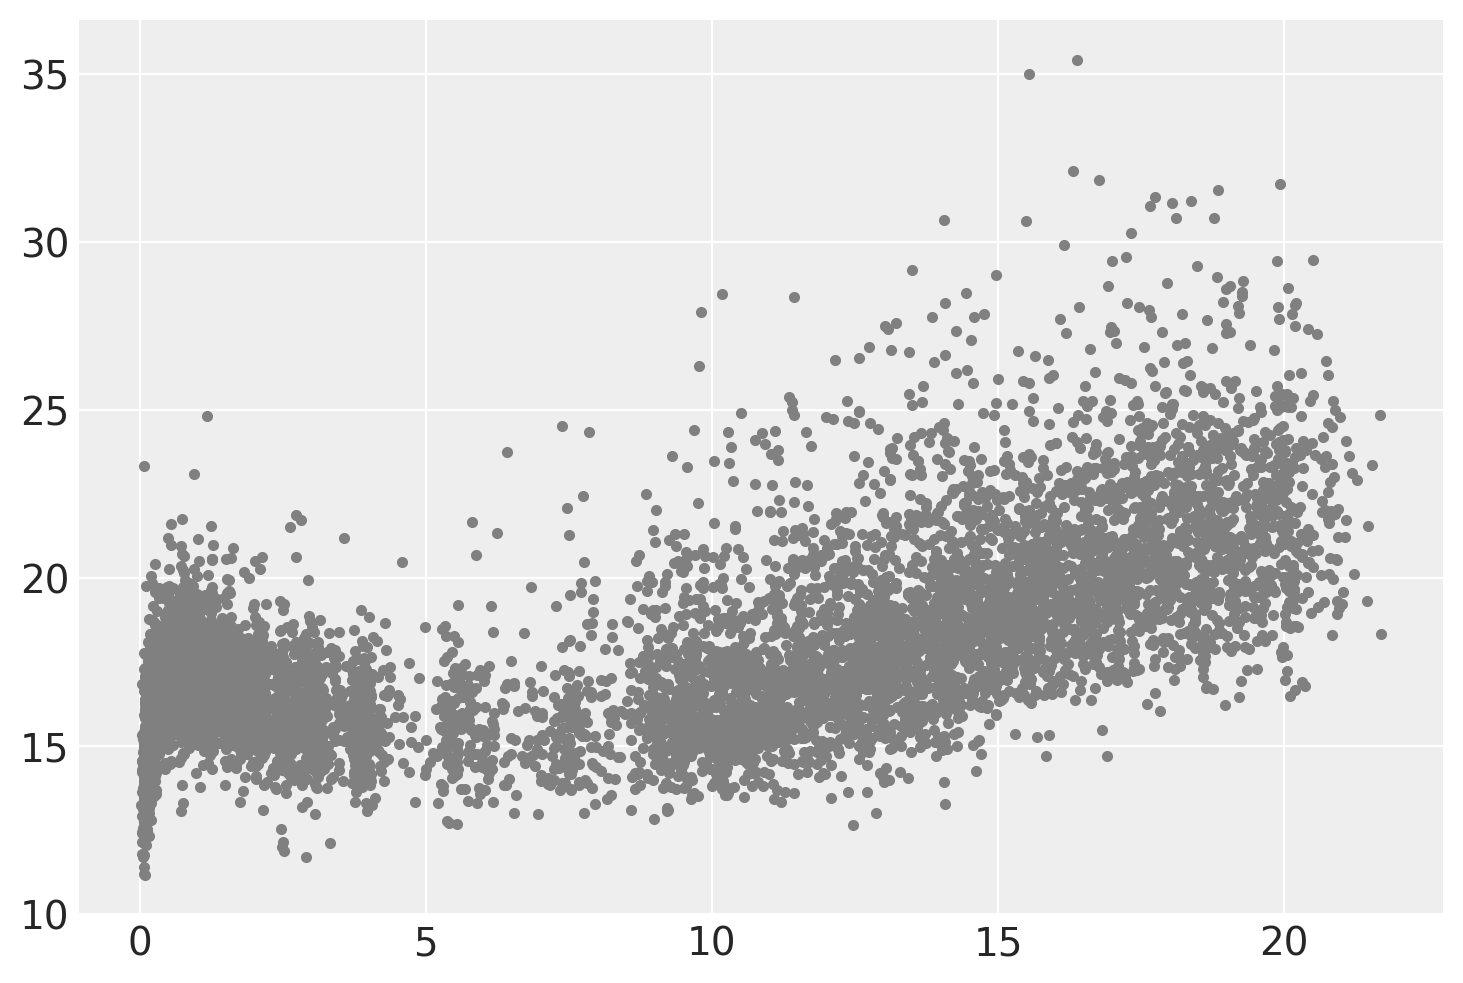

In [9]:
plt.plot(bmi.age, bmi.bmi, ".", color="0.5")
for idx, q in enumerate(quantiles[:, 0]):
    plt.plot(
        bmi.age,
        idata.posterior["μ"].mean(("chain", "draw")).sel(μ_dim_0=idx),
        label=f"q={q:}",
        lw=3,
    )

plt.legend();

In [10]:
y = bmi.bmi.values
x = bmi.age.values[:, None]
with pm.Model() as model:
    μ = pm.BART("μ", x, y)
    σ = pm.HalfNormal("σ", 5)
    obs = pm.Normal("obs", mu=μ, sigma=σ, observed=y)

    idata_g = pm.sample(compute_convergence_checks=False)
    idata_g.extend(pm.sample_posterior_predictive(idata_g))

/tmp/ipykernel_1378706/427134491.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  idata_g = pm.sample(compute_convergence_checks=False)
The BART model is experimental. Use with caution.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [μ]
>NUTS: [σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 73 seconds.


AttributeError: 'MultiTrace' object has no attribute 'extend'

In [ ]:
idata_g_mean_quantiles = idata_g.posterior_predictive["obs"].quantile(
    quantiles[:, 0], ("chain", "draw")
)

In [ ]:
plt.plot(bmi.age, bmi.bmi, ".", color="0.5")
for q in quantiles[:, 0]:
    plt.plot(bmi.age.values, idata_g_mean_quantiles.sel(quantile=q), label=f"q={q:}")

plt.legend()
plt.xlabel("Age")
plt.ylabel("BMI");